In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
import statistics
from scipy import stats

# "Lost At Six Flags" 
### Can you find your friend faster if you are both moving or if they are standing still?
###### Ben Hendel


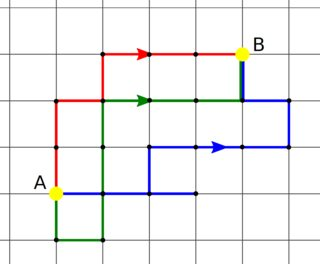

Imagine you and a friend are lost. 

Should you both look for each other or should one of you stay in place until the other one finds them? 

My idea is to test if two people can find each other faster if they both move around or if one stands still. The basic idea is to create a coordinate grid of numbers to traverse on in a 2D random walk, where the simulation ends when they intersect. Basic statistics of how many iterations it took are observed, and strategies are compared

-----------

I wish to fully explore the problem by tweaking various parameters that influence time of convergence, such as:

##### Initial Position (central, edge, random)

##### Initial Distance (1, 2, 3, opposite sides, random)

##### Grid Size (20x20, 30x30, 50x50, 100x100...)



And later, if possible:

Grid Shape (Rectangle, Triangle, Hex)

Agent's Speed (1, 2, 3 ,5...)

Search Logic (Random Walk, Random Walk in one axis, optimal, etc)

Obstacles/ Line of Sight (LOS)

## Preparatory code

In [2]:
def reset_grid(width, height):    # re-initializes the grid of given size for a new run
    global previous_x1
    global previous_y1
    global previous_x2 
    global previous_y2
    global grid_width
    global grid_height
    global max_width
    global max_height
    global counter
    
    previous_x1 = None
    previous_y1 = None
    previous_x2 = None
    previous_y2 = None
    grid_width = range(width + 1)
    grid_height = range(height + 1)
    max_width = grid_width[-1]
    max_height = grid_height[-1]
    counter = 0

In [3]:
reset_grid(20, 20)

In [4]:
def update_grid(new_x1, new_y1, new_x2=10, new_y2=10, alpha=1):    # updates positions on graph and plots
    global previous_x1
    global previous_y1
    global previous_x2
    global previous_y2
    global counter     # Counts total steps
    
    plt.figure(figsize=[3,3])
    [plt.plot([x,x],[0, max_height],color='k') for x in grid_width]
    [plt.plot([0, max_width],[y,y],color='k') for y in grid_height]
        
    if previous_x1 and previous_y1:
        plt.scatter(previous_x1 , previous_y1, color = "red", alpha=0.25, zorder=10, s=100)
    if previous_x2 and previous_y2:
        plt.scatter(previous_x2, previous_y2, color = "blue", alpha=0.25, zorder=10, s=100)
    plt.scatter(new_x1, new_y1, color = "red", alpha=1, zorder=10, s=100)
    plt.scatter(new_x2, new_y2, color = "blue", alpha=1, zorder=10, s=100)
    plt.show()

    previous_x1 = new_x1
    previous_y1 = new_y1
    previous_x2 = new_x2
    previous_y2 = new_y2
    counter += 1

We represent the two "lost" agents as two points on a map, blue and red. Here you can see where they are on the grid, as well as where they were one move ago

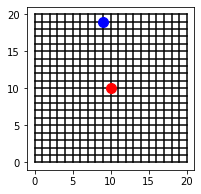

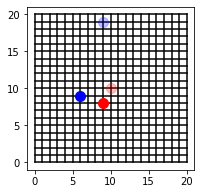

In [5]:
update_grid(10, 10, 9, 19, alpha=0.2)
update_grid(9, 8, 6, 9, alpha=0.4)


Unique objects are created for agents and the grid itself. An agent is either moving or stationary, and has a speed and starting coordinates. The agent is constrained to the boundaries of the grid area and it also intelligently "bounces" back in after hitting a wall. This is more realistic and prevents the agents from getting stuck in corners for extended periods. 

I also made it impossible to move back to the same square you just came from, since this is an unrealistic way to look for someone.

In [6]:
class Agent():
    def __init__(self, start_x, start_y, speed=1, moving = True, search="random walk", LOS=5):
        self.start_x = start_x
        self.start_y = start_y
        self.x = start_x
        self.y = start_y
        self.speed = speed
        self.search = search
        self.LOS = LOS
        self.moving = moving
        self.turns = 0
        self.distance_traveled = 0
    
    def is_outside_grid(self):
        if self.x > max_width or self.y > max_height:
            return True
        else:
            return False
    
    def get_position(self):
        return((self.x, self.y))
    
    
    def move_one(self):     # Runs one turn/ random walk
        skipped = False
        if not self.moving:
            return None
        if self.search == "random walk":
            
            step_x = None
            step_y = None
            
            if self.x == 0:                            # bounces right when on left edge
                step_x = random.randint(1, self.speed)
            if self.x == max_width:                   # bounces left when on right edge
                step_x = random.randint(-1*self.speed, -1)
            if self.y == 0:                            # bounces up when on bottom edge
                step_y = random.randint(1, self.speed)
            if self.y == max_height:                  # bounces down when on top edge
                step_y = random.randint(-1*self.speed, -1)

            if step_x is None:
                step_x = random.randint(-1*self.speed, self.speed)
            if step_y is None:
                step_y = random.randint(-1*self.speed, self.speed)

            if step_x == 0 and step_y == 0:  # handle case when agent randomly stays in place by accident
                self.move_one()
                skipped = True
                

            if not skipped:    # move and compile statistics
                self.x += step_x
                self.y += step_y          
                self.turns += 1
                self.distance_traveled += np.abs(step_x)
                self.distance_traveled += np.abs(step_y)   
            
            
        elif search == "semirandom":    # for future use
            pass
        
        elif search == "optimal":       # for future use
            pass

In [7]:
def check_if_converge(agent1, agent2):      # Checks if agents are at the same location
    if agent1.x == agent2.x and agent1.y == agent2.y:
        return True
    else:
        return False

In [8]:
agent2 = Agent(10, 10)
agent1 = Agent(19, 19)
check_if_converge(agent1, agent2)

False

In [9]:
def experiment(start_x1 = 5, start_y1 = 10, start_x2 = 15, start_y2 = 10, iterations = 2000, width = 20, height = 20, moving = "one", plot = True, hist = False, plot_steps = False):
    distances = []                    # Executes a run of several iterations and collects statistics, histogram, returns average
    end_locations = []
    reset_grid(width, height)
    
    if plot:
        update_grid(start_x1, start_y1, start_x2, start_y2, alpha=1)
    for iteration in range(iterations):
        agent1 = Agent(start_x1, start_y1)
        agent2 = Agent(start_x2, start_y2)

        while not check_if_converge(agent1, agent2):       # while loop that moves agent until coordinates overlap
            
            agent1.move_one()                       # move first agent
            
            if moving == "both":
                agent2.move_one()                   # move second agent
            
            if plot_steps:                                 # show intermediate plots every step if requested
                plt.figure(figsize=[4,4])

                [plt.plot([x,x],[0, height],color='k') for x in grid_width]
                [plt.plot([0, width],[y,y],color='k') for y in grid_height]

                plt.scatter(agent1.get_position()[0], agent1.get_position()[1], color = "red", alpha=1, zorder=10, s=100)
                plt.scatter(agent2.get_position()[0], agent2.get_position()[1], color = "blue", alpha=1, zorder=10, s=100)

                plt.show()


                

        distances.append(agent1.distance_traveled)
        end_locations.append(agent1.get_position())

        reset_grid(width, height)

        agent1 = Agent(start_x1, start_y1)
        agent2 = Agent(start_x2, start_y2)
    
    if plot:                        # show verbose output if requested
        print(f"Start location: {start_x1, start_y1, start_x2, start_y2}")
        print(f"Iterations: {iterations}")
        print(f"Grid size: {width, height}")
        print(f"Agents moving: {moving}")
        print(f"Mean end location: {sum(xcoord[0] for xcoord in end_locations)/len(end_locations), sum(xcoord[1] for xcoord in end_locations)/len(end_locations)}")
        print(f"Average turns to convergence: {sum(distances)/len(distances)}")
        print(f"95% Confidence interval for mean: {confidence_interval(sum(distances)/len(distances), statistics.stdev(distances), iterations)}")
        print(f"Median turns to convergence: {statistics.median(distances)}")
        print(f"Standard Deviation: {round(statistics.stdev(distances))}")
        if hist:
            plt.figure(figsize=[3,3])
            pd.Series(distances).hist()
            plt.xlabel("moves")
            plt.ylabel("count")
            plt.title("Distribution")
            plt.show()
    return sum(distances)/len(distances)
    

In [10]:
def confidence_interval(mean1, s1, n1, mean2 = None, s2 = None, n2 = None, two_sample = False):
    if two_sample:
        v1 = (((s1**2)/n1) + ((s2**2)/n2))**2
        v2 = (((s1**2)/n1)**2)/(n1+1)
        v3 = (((s2**2)/n2)**2)/(n2+1)
        v = math.floor((v1/(v2 + v3)) - 2)
        t = stats.t.ppf(q=1-(0.05/2), df=v)
        upper = mean1 - mean2 + (((s1**2)/n1) + ((s2**2)/n2))**0.5
        lower = mean1 - mean2 - (((s1**2)/n1) + ((s2**2)/n2))**0.5
        return (min([lower, upper]), max([lower, upper]))
    else:
        t = stats.t.ppf(q=1-(0.05/2), df=n1-1)
        upper = mean1 + (t*s1/(n1**0.5))
        lower = mean1 - (t*s1/(n1**0.5))
        return (round(min([lower, upper]), 2), round(max([lower, upper]), 2))
        

With that, let's take a look at a simple example of a both-moving search on a small 2x2 grid. Note here that diagonal motion is allowed

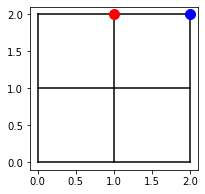

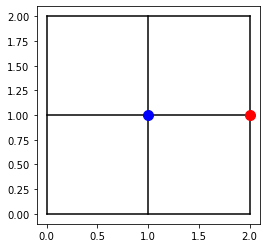

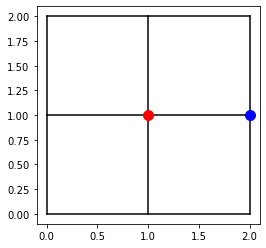

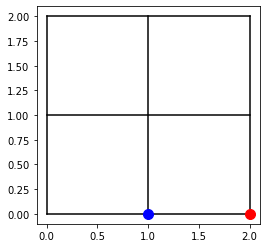

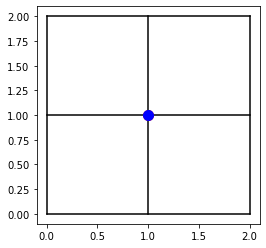

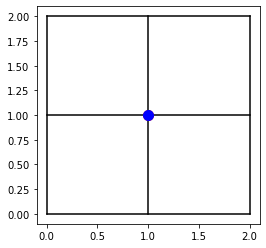

Start location: (1, 2, 2, 2)
Iterations: 2
Grid size: (2, 2)
Agents moving: both
Mean end location: (1.0, 1.0)
Average turns to convergence: 4.0
95% Confidence interval for mean: (-34.12, 42.12)
Median turns to convergence: 4.0
Standard Deviation: 4


4.0

In [11]:
random.seed(19)
experiment(1, 2, 2, 2, width=2, height=2, moving="both", plot_steps = True, iterations=2)


## Start of Experiments

Looks good, let's start doing full runs of many iterations, first looking at the case of only one agent moving

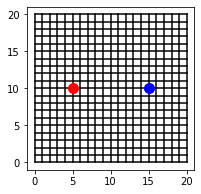

Start location: (5, 10, 15, 10)
Iterations: 20000
Grid size: (20, 20)
Agents moving: one
Mean end location: (15.0, 10.0)
Average turns to convergence: 1234.7423
95% Confidence interval for mean: (1219.11, 1250.38)
Median turns to convergence: 898.0
Standard Deviation: 1128


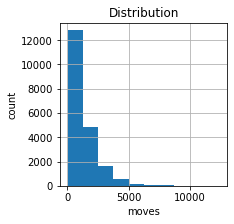

1234.7423

In [12]:
random.seed(10)
experiment(5, 10, 15, 10, iterations=20000, hist=True)

In the standard one-moving case with normally spaced points on a grid, it took an average of 1234.74 moves until the agent reached its destination, with the time being distributed roughly exponentially. Let's compare that to the Both Moving scenario.

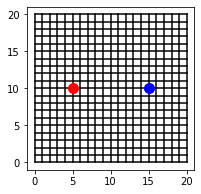

Start location: (5, 10, 15, 10)
Iterations: 20000
Grid size: (20, 20)
Agents moving: both
Mean end location: (10.00525, 9.94365)
Average turns to convergence: 1070.0366
95% Confidence interval for mean: (1056.16, 1083.92)
Median turns to convergence: 760.0
Standard Deviation: 1002


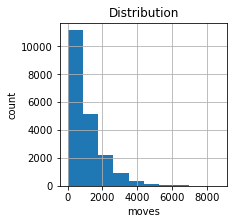

1070.0366

In [13]:
random.seed(10)
experiment(5, 10, 15, 10, iterations=20000, moving="both", hist=True)


It appears that both moving is faster, with a smaller mean, median, and standard deviation.

In [14]:
print("Difference in means CI:")
confidence_interval(1214, 1118, 20000, 1061, 1013, 20000, two_sample=True) 

Difference in means CI:


(142.33207377228356, 163.66792622771644)

Let's see how that changes when we change the starting positions of the points, bringing them closer together

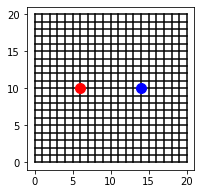

Start location: (6, 10, 14, 10)
Iterations: 2000
Grid size: (20, 20)
Agents moving: one
Mean end location: (14.0, 10.0)
Average turns to convergence: 1174.095
95% Confidence interval for mean: (1125.47, 1222.72)
Median turns to convergence: 861.0
Standard Deviation: 1109


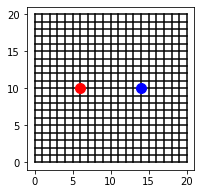

Start location: (6, 10, 14, 10)
Iterations: 2000
Grid size: (20, 20)
Agents moving: both
Mean end location: (9.9725, 10.0025)
Average turns to convergence: 1059.889
95% Confidence interval for mean: (1015.23, 1104.55)
Median turns to convergence: 752.0
Standard Deviation: 1018


1059.889

In [15]:
random.seed(20)
experiment(6, 10, 14, 10, iterations=2000)
random.seed(20)
experiment(6, 10, 14, 10, iterations=2000, moving="both")

Predictably, starting closer together decreases both averages slightly, and Both Moving is once again faster (1059 turns vs 1174 turns)

Let's try starting much closer together

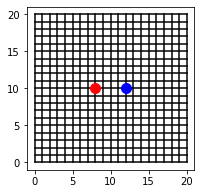

Start location: (8, 10, 12, 10)
Iterations: 20000
Grid size: (20, 20)
Agents moving: one
Mean end location: (12.0, 10.0)
Average turns to convergence: 900.4343
95% Confidence interval for mean: (886.73, 914.14)
Median turns to convergence: 586.0
Standard Deviation: 989


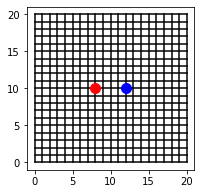

Start location: (8, 10, 12, 10)
Iterations: 20000
Grid size: (20, 20)
Agents moving: both
Mean end location: (9.9905, 10.02815)
Average turns to convergence: 937.87385
95% Confidence interval for mean: (923.91, 951.84)
Median turns to convergence: 625.0
Standard Deviation: 1008


937.87385

In [16]:
random.seed(30)
experiment(8, 10, 12, 10, iterations=20000)
random.seed(30)
experiment(8, 10, 12, 10, iterations=20000, moving="both")

Interestingly, now one stationary is faster! 

The likely explanation is that it's hard to find someone on an edge if you are moving randomly, but if they remain firmly in the center, that's a location that is passed multiple times

Now let's try an extreme configuration: Both points starting on the very edge of the map

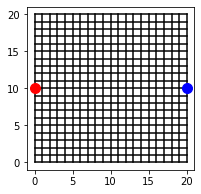

Start location: (0, 10, 20, 10)
Iterations: 1000
Grid size: (20, 20)
Agents moving: one
Mean end location: (20.0, 10.0)
Average turns to convergence: 2922.108
95% Confidence interval for mean: (2750.25, 3093.97)
Median turns to convergence: 2137.0
Standard Deviation: 2769


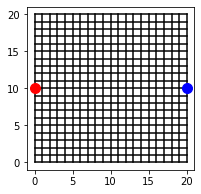

Start location: (0, 10, 20, 10)
Iterations: 1000
Grid size: (20, 20)
Agents moving: both
Mean end location: (10.137, 10.163)
Average turns to convergence: 1143.756
95% Confidence interval for mean: (1077.74, 1209.78)
Median turns to convergence: 791.0
Standard Deviation: 1064


1143.756

In [17]:
random.seed(40)
experiment(0, 10, 20, 10, iterations=1000)
random.seed(40)
experiment(0, 10, 20, 10, iterations=1000, moving="both")

Both moving vastly overperforms one moving, likely due to the effect of "bouncing" off the walls

## Initial results based on starting position

Let's summarize these results in a graph. For reference, here are our starting positions:

Through middle


<Figure size 144x144 with 0 Axes>

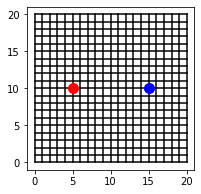

5 rows from the bottom


<Figure size 144x144 with 0 Axes>

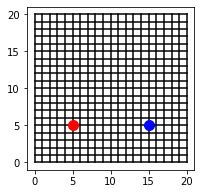

2 rows from the bottom


<Figure size 144x144 with 0 Axes>

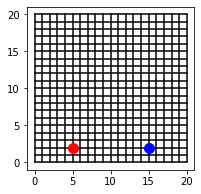

bottom


<Figure size 144x144 with 0 Axes>

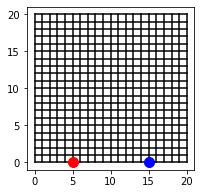

In [18]:
reset_grid(20,20)
plt.figure(figsize=[2,2])
print("Through middle")
update_grid(5, 10, 15, 10, alpha=0.2)

reset_grid(20,20)
plt.figure(figsize=[2,2])
print("5 rows from the bottom")
update_grid(5, 5, 15, 5, alpha=1)

reset_grid(20,20)
plt.figure(figsize=[2,2])
print("2 rows from the bottom")
update_grid(5, 2, 15, 2, alpha=1)

reset_grid(20,20)
plt.figure(figsize=[2,2])
print("bottom")
update_grid(5, 0, 15, 0, alpha=1)

In [19]:
def populate(height, xlist, ylist, ylist_both):
    for d in range(10):
        random.seed(60)
        xlist.append(20-2*d)
        time = experiment(d, height, 20-d, height, iterations=2000, plot=False)
        random.seed(60)
        ylist.append(time)
        time_both = experiment(d, height, 20-d, height, iterations=2000, plot=False, moving="both")
        ylist_both.append(time_both)
    

In [20]:
initial_distances = []
convergence_times = []
convergence_times_both = []

populate(10, initial_distances, convergence_times, convergence_times_both)

initial_distances_bottom = []
convergence_times_bottom = []
convergence_times_bottom_both = []

populate(0, initial_distances_bottom, convergence_times_bottom, convergence_times_bottom_both)

initial_distances_quarter = []
convergence_times_quarter = []
convergence_times_quarter_both = []

populate(5, initial_distances_quarter, convergence_times_quarter, convergence_times_quarter_both)

initial_distances_near_bottom = []
convergence_times_near_bottom = []
convergence_times_near_bottom_both = []

populate(2, initial_distances_near_bottom, convergence_times_near_bottom, convergence_times_near_bottom_both)

(0.0, 5000.0)

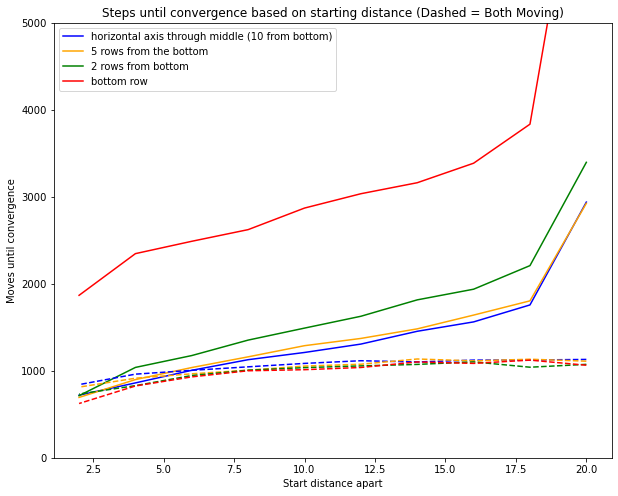

In [21]:
plt.figure(figsize=[10,8])
plt.plot(initial_distances, convergence_times, color = "blue")
plt.plot(initial_distances_quarter, convergence_times_quarter, color = "orange")
plt.plot(initial_distances_near_bottom, convergence_times_near_bottom, color = "green")
plt.plot(initial_distances_bottom, convergence_times_bottom, color = "red")

plt.plot(initial_distances, convergence_times_both, color = "blue", linestyle = "dashed")
plt.plot(initial_distances_quarter, convergence_times_quarter_both, color = "orange", linestyle = "dashed")
plt.plot(initial_distances_near_bottom, convergence_times_near_bottom_both, color = "green", linestyle = "dashed")
plt.plot(initial_distances_bottom, convergence_times_bottom_both, color = "red", linestyle = "dashed")

plt.legend([r"horizontal axis through middle (10 from bottom)", "5 rows from the bottom", "2 rows from bottom", "bottom row"])
plt.title(r"Steps until convergence based on starting distance (Dashed = Both Moving)")
plt.xlabel("Start distance apart")
plt.ylabel("Moves until convergence")
plt.ylim([0, 5000])

Wow! A way better overall performance by all the both-moving searches. Since both agents start by moving and tend towards center, starting distance is pretty much a non factor, especially after a few moves. On the other hand, if one agent is stationary, it has to make it's way all the way close to a specific edge without getting lost too much. However, as observed before, for very small start distance (Around 4 or less), one moving performs slightly better.

For one agent stationary the trend is clear: Increase the start distance by one and the convergence time increases by 50 to 80 iterations (increasing as you go along). The effect is not quite exponential, but slightly above linear. The pattern is the same whether you start on the center horizontal axis or not, until you get to the edges, then it changes dramatically: Making a point have to converge to the edge is challenging because of the coded in bouncing-off effect, meaning an agent can't walk along the edge. This is realistic, since a human searching for a friend would return closer to the center after hitting a boundary, and straddling it would be an ineffective strategy. Variance didn't differ and was somewhat proportional to average steps to convergence, meaning the best strategy was also always the least risky.

------------

## Grid Sizes

Let's look at the effect of size, starting by upping the grid to 30 by 30.

Now there is more room for an agent to get "lost" for several hundred turns, which makes performance sluggish

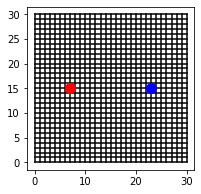

Start location: (7, 15, 23, 15)
Iterations: 1000
Grid size: (30, 30)
Agents moving: one
Mean end location: (23.0, 15.0)
Average turns to convergence: 3012.406
95% Confidence interval for mean: (2844.6, 3180.21)
Median turns to convergence: 2262.0
Standard Deviation: 2704


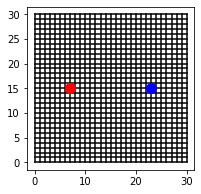

Start location: (7, 15, 23, 15)
Iterations: 1000
Grid size: (30, 30)
Agents moving: both
Mean end location: (14.892, 15.15)
Average turns to convergence: 2495.902
95% Confidence interval for mean: (2352.85, 2638.96)
Median turns to convergence: 1797.0
Standard Deviation: 2305


2495.902

In [22]:
random.seed(70)
experiment(7, 15, 23, 15, width=30, height=30, iterations=1000)
random.seed(70)
experiment(7, 15, 23, 15, width=30, height=30, iterations=1000, moving="both")

Both moving once again performs better. Let's try a variety of grid sizes: 4x4, 10x10, 20x20, 30x30, 50x50, and even 100x100

In [23]:
grid_sizes = [4, 10, 20, 30, 50, 100]
convergence_times = []
convergence_times_both = []

for size in grid_sizes:
    random.seed(80)
    time = experiment(round(size*0.333), size*0.5, round(size*0.666), size*0.5, iterations=round(20000/size), width=size, height=size, plot=False)
    convergence_times.append(time)
    random.seed(80)
    time_both = experiment(round(size*0.333), size*0.5, round(size*0.666), size*0.5, iterations=round(20000/size), width=size, height=size, plot=False, moving="both")
    convergence_times_both.append(time_both)

In [24]:
convergence_times   # one moving, grid edge grid_sizes = 4, 10, 20, 30, 50, 100

[31.0788, 230.978, 960.918, 2718.0269865067467, 7454.395, 36033.89]

In [25]:
convergence_times_both    # both moving, grid edge grid_sizes = 4, 10, 20, 30, 50, 100

[35.5628, 244.112, 1010.335, 2471.184407796102, 7493.085, 28575.915]

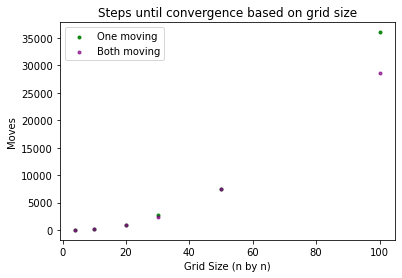

In [26]:
plt.scatter(grid_sizes, np.array(convergence_times), color="green", alpha=0.9, marker=".")
plt.scatter(grid_sizes, np.array(convergence_times_both), color="purple", alpha=0.7, marker=".")
plt.title("Steps until convergence based on grid size")
plt.xlabel(r"Grid Size (n by n)")
plt.ylabel("Moves")
plt.legend(["One moving", "Both moving"])
plt.show()

Overall, both-moving performs better for large grid sizes (30x30, 50x50, 100x100). One-moving performs slightly better for small grid sizes (less than 20x20).

Doubling the grid size from 10x10 to 20x20 increased convergence time by factor of around 4, and doubling from 50x50 to 100x100 increased it by a factor of 4.6

However, this ignores the effect of starting far away. To make things extreme, let's generate the same graph but with starting points being near opposit corners of the grid

In [28]:
grid_sizes = [4, 10, 20, 30, 50, 100]
convergence_times = []
convergence_times_both = []

for size in grid_sizes:
    random.seed(90)
    time = experiment(1, round(size*0.1), round(size*0.9), round(size*0.9), iterations=round(20000/size), width=size, height=size, plot=False)
    convergence_times.append(time)
    random.seed(90)
    time_both = experiment(round(size*0.333), size*0.5, round(size*0.666), size*0.5, iterations=round(20000/size), width=size, height=size, plot=False, moving="both")
    convergence_times_both.append(time_both)

In [29]:
convergence_times

[218.0212, 519.391, 2265.114, 5516.7856071964015, 15454.4, 64297.06]

In [30]:
convergence_times_both

[35.205, 239.214, 1032.856, 2408.4287856071965, 7047.625, 29268.83]

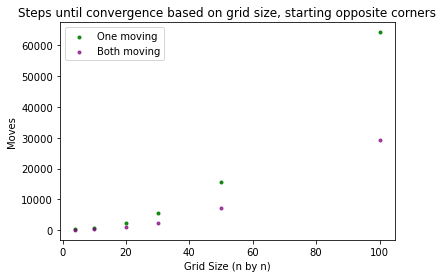

In [31]:
plt.scatter(grid_sizes, convergence_times, color="green", alpha=0.9, marker=".")
plt.scatter(grid_sizes, convergence_times_both, color="purple", alpha=0.7, marker=".")
plt.title("Steps until convergence based on grid size, starting opposite corners")
plt.xlabel(r"Grid Size (n by n)")
plt.ylabel("Moves")
plt.legend(["One moving", "Both moving"])
plt.show()

Wow! Much better! Both moving is far superior in these kinds of situations

----

Overall conclusion: 

# Both agents searching is usually a better strategy!

One stationary was a better strategy in one of a few specific conditions. These are:

##### The grid is small and can be traversed in few steps

or

##### Agents start very close together


So, long story short, if you have to find a random stranger at the theme park, you may want to both look for each other. If you are with someone in a small room and lose contact? Stay still.

## Accuracy and future steps

The accuracy of the simulation rests upon how well it replicates reality. In real life, some of these underlying assumptions are violated. For example, when someone searches for someone, they don't exactly move randomly. They move in a way that captures new territory and roughly avoids repeat the same areas. This kind of movement is somewhat deterministic and somewhat stochastic, and is hard to capture in the code. The current implementation just avoids the last space the agent came from, but there can still be unrealistic "cycles" of a few moves. Further efforts will adjust the search to prefer avoiding spaces that have been visited, those that have been stored in a queue representing the "history" of the agent's travels.

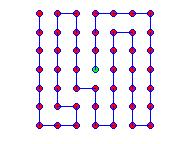

In reality, the random walk performances are insuficcient. In fact, they can all be beaten by simply having one agent stay in place while the other agent performs a full sweep of every space in the grid! So it's easy to see why an "intelligent" search is needed.

In addition, there is the aspect of sight. In reality, you find someone when you see them. To properly determine this, a simulation should have a random "visibility" component, represented by things like line-of-sight and obstacles placed on the grid. A hexgrid of hexagons (using Uber's H3 library) would be a better simulation of motion since it allows diagonal motion, not just orthogonal/diagonal. This will be done in a future implementation, as well as adding the effects of walking speeds, and differently shaped grids.

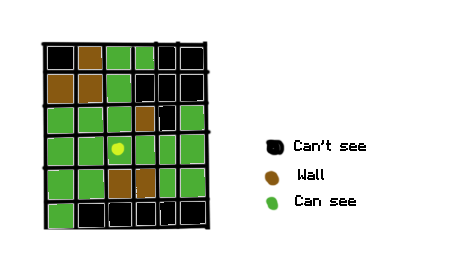

Overall, Python and Jupyter notebooks were simple and convenient tools that were perfect for solving this problem. Simulation software, such as ARENA, was used at the beginning but failed and didn't allow enough flexibility for some aspects. For any questions about this project or my career, email me at bhendel@ucdavis.edu